In [1]:
from pathlib import Path
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    PROJECT_ROOT = Path("/content/drive/MyDrive/ABT_Global/AI-Studio-Project")
except ImportError:
    PROJECT_ROOT = Path("../..").resolve()
PROCESSED = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Data: {PROCESSED}")
print(f"Models: {MODELS_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data: /content/drive/MyDrive/ABT_Global/AI-Studio-Project/data/processed
Models: /content/drive/MyDrive/ABT_Global/AI-Studio-Project/models


## Environment Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the stratified splits using dynamic paths
try:
    train_df = pd.read_csv(PROCESSED / "train_df.csv")
    val_df = pd.read_csv(PROCESSED / "val_df.csv")
    test_df = pd.read_csv(PROCESSED / "test_df.csv")
    print("Successfully loaded stratified splits")
except FileNotFoundError:
    print("Split files not found. Please run the data splitting code first.")
    raise

print("Dataset shapes:")
print(f"   Training: {train_df.shape}")
print(f"   Validation: {val_df.shape}")
print(f"   Test: {test_df.shape}")

Successfully loaded stratified splits
Dataset shapes:
   Training: (2385681, 24)
   Validation: (795227, 24)
   Test: (795227, 24)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the stratified splits using dynamic paths
try:
    train_df = pd.read_csv(PROCESSED / "train_df.csv")
    val_df = pd.read_csv(PROCESSED / "val_df.csv")
    test_df = pd.read_csv(PROCESSED / "test_df.csv")
    print("Successfully loaded stratified splits")
except FileNotFoundError:
    print("Split files not found. Please run the data splitting code first.")
    raise

print("Dataset shapes:")
print(f"   Training: {train_df.shape}")
print(f"   Validation: {val_df.shape}")
print(f"   Test: {test_df.shape}")


# Prepare features and target (same as Gradient Boosting)
def prepare_features_targets(train_df, val_df, test_df):
    """Prepare features and targets for modeling using target encoding for high-cardinality categoricals"""

    # Columns to exclude (metadata, target, and non-numeric that won't be encoded/used as features)
    # 'month' will now be included as a feature.
    exclude_cols = ['outage_occurred', 'date', 'fips_code', 'month_name']

    # High cardinality categorical columns for target encoding (matching GB output)
    target_encode_cols = ['county', 'state']

    # Make copies to avoid modifying original DataFrames directly
    train_df_processed = train_df.copy()
    val_df_processed = val_df.copy()
    test_df_processed = test_df.copy()

    # Target Encoding (Mean Encoding) for high-cardinality features
    # Calculate mappings only on training data to avoid data leakage
    global_mean_outage = train_df_processed['outage_occurred'].mean()

    print(f"Applying Target Encoding for: {target_encode_cols}")
    for col in target_encode_cols:
        # Calculate mapping from training data
        mapping = train_df_processed.groupby(col)['outage_occurred'].mean().to_dict()

        # Apply mapping to all datasets, using a distinct name to avoid collision
        train_df_processed[f'{col}_target_encoded'] = train_df_processed[col].map(mapping).fillna(global_mean_outage)
        val_df_processed[f'{col}_target_encoded'] = val_df_processed[col].map(mapping).fillna(global_mean_outage)
        test_df_processed[f'{col}_target_encoded'] = test_df_processed[col].map(mapping).fillna(global_mean_outage)

        # Add original categorical column to exclude list so it's not used directly as a feature
        exclude_cols.append(col)

    # Label Encode 'prcp_category' (assuming this is how GB made it numeric as a single feature)
    print("Applying Label Encoding for: ['prcp_category']")
    le = LabelEncoder()
    train_df_processed['prcp_category_encoded'] = le.fit_transform(train_df_processed['prcp_category'])
    val_df_processed['prcp_category_encoded'] = le.transform(val_df_processed['prcp_category'])
    test_df_processed['prcp_category_encoded'] = le.transform(test_df_processed['prcp_category'])
    exclude_cols.append('prcp_category') # Exclude original string column


    # Get feature columns (only those present in all datasets after encoding and not in exclude_cols)
    common_cols = set(train_df_processed.columns) & set(val_df_processed.columns) & set(test_df_processed.columns)
    feature_cols = [col for col in common_cols if col not in exclude_cols]

    print(f"Using {len(feature_cols)} features:")
    for i, col in enumerate(feature_cols[:10]):  # Show first 10 features
        print(f"  {i+1}. {col}")
    if len(feature_cols) > 10:
        print(f"  ... and {len(feature_cols) - 10} more features")

    # Prepare features and targets
    X_train = train_df_processed[feature_cols]
    y_train = train_df_processed['outage_occurred']

    X_val = val_df_processed[feature_cols]
    y_val = val_df_processed['outage_occurred']

    X_test = test_df_processed[feature_cols]
    y_test = test_df_processed['outage_occurred']

    return X_train, X_val, X_test, y_train, y_val, y_test, feature_cols

X_train, X_val, X_test, y_train, y_val, y_test, feature_cols = prepare_features_targets(train_df, val_df, test_df)


# Check class distribution
print("Class distribution in each set:")
print(f"Training - Outages: {y_train.sum():,} ({y_train.mean():.3%})")
print(f"Validation - Outages: {y_val.sum():,} ({y_val.mean():.3%})")
print(f"Test - Outages: {y_test.sum():,} ({y_test.mean():.3%})")

Successfully loaded stratified splits
Dataset shapes:
   Training: (2385681, 24)
   Validation: (795227, 24)
   Test: (795227, 24)
Applying Target Encoding for: ['county', 'state']
Applying Label Encoding for: ['prcp_category']
Using 20 features:
  1. is_weekend
  2. has_precipitation
  3. tmax
  4. region_encoded
  5. day_of_year_cos
  6. temp_stress
  7. month
  8. county_target_encoded
  9. combined_extreme
  10. day
  ... and 10 more features
Class distribution in each set:
Training - Outages: 1,104,111 (46.281%)
Validation - Outages: 368,036 (46.281%)
Test - Outages: 368,037 (46.281%)


In [4]:
# Scale features (CRITICAL for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")

Feature scaling completed


In [5]:
# Initialize Logistic Regression model with class weight balancing
print("Training Logistic Regression model...")
lr_model = LogisticRegression(
    C=1.0,                    # Regularization strength
    class_weight='balanced',  # Adjust for class imbalance
    random_state=42,
    max_iter=1000,           # Ensure convergence
    solver='liblinear',       # Good for smaller datasets
    penalty='l2'             # Ridge regularization
)

# Train the model
lr_model.fit(X_train_scaled, y_train)
print("✅ Logistic Regression training completed!")

Training Logistic Regression model...
✅ Logistic Regression training completed!


In [6]:
# Make predictions on all sets
y_train_pred = lr_model.predict(X_train_scaled)
y_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]

y_val_pred = lr_model.predict(X_val_scaled)
y_val_proba = lr_model.predict_proba(X_val_scaled)[:, 1]

y_test_pred = lr_model.predict(X_test_scaled)
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

def evaluate_model(y_true, y_pred, y_proba, dataset_name):
    """Comprehensive model evaluation"""

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  # Most important for outage prediction
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)

    # Create metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

    # Print results
    print(f"\n{'='*50}")
    print(f"{dataset_name.upper()} SET EVALUATION")
    print(f"{'='*50}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Recall:    {recall:.4f}  ← Most important for outage prediction")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Class distribution
    print(f"\nClass Distribution:")
    print(f"Class 0 (No Outage): {np.sum(y_true == 0):,} samples")
    print(f"Class 1 (Outage):    {np.sum(y_true == 1):,} samples")
    print(f"Outage Rate: {(np.sum(y_true == 1) / len(y_true)):.3f}")

    return metrics

# Evaluate on all datasets
print("LOGISTIC REGRESSION MODEL PERFORMANCE")
print("=" * 60)
train_metrics = evaluate_model(y_train, y_train_pred, y_train_proba, "training")
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, "validation")
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, "test")

LOGISTIC REGRESSION MODEL PERFORMANCE

TRAINING SET EVALUATION
Accuracy:  0.6832
Recall:    0.7045  ← Most important for outage prediction
Precision: 0.6442
F1-Score:  0.6730
ROC-AUC:   0.7463

Class Distribution:
Class 0 (No Outage): 1,281,570 samples
Class 1 (Outage):    1,104,111 samples
Outage Rate: 0.463

VALIDATION SET EVALUATION
Accuracy:  0.6836
Recall:    0.7043  ← Most important for outage prediction
Precision: 0.6448
F1-Score:  0.6732
ROC-AUC:   0.7464

Class Distribution:
Class 0 (No Outage): 427,191 samples
Class 1 (Outage):    368,036 samples
Outage Rate: 0.463

TEST SET EVALUATION
Accuracy:  0.6829
Recall:    0.7045  ← Most important for outage prediction
Precision: 0.6438
F1-Score:  0.6728
ROC-AUC:   0.7459

Class Distribution:
Class 0 (No Outage): 427,190 samples
Class 1 (Outage):    368,037 samples
Outage Rate: 0.463


In [7]:
# Create detailed classification reports
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT - TEST SET")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=['No Outage', 'Outage']))


DETAILED CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

   No Outage       0.72      0.66      0.69    427190
      Outage       0.64      0.70      0.67    368037

    accuracy                           0.68    795227
   macro avg       0.68      0.68      0.68    795227
weighted avg       0.69      0.68      0.68    795227



CONFUSION MATRIX ANALYSIS


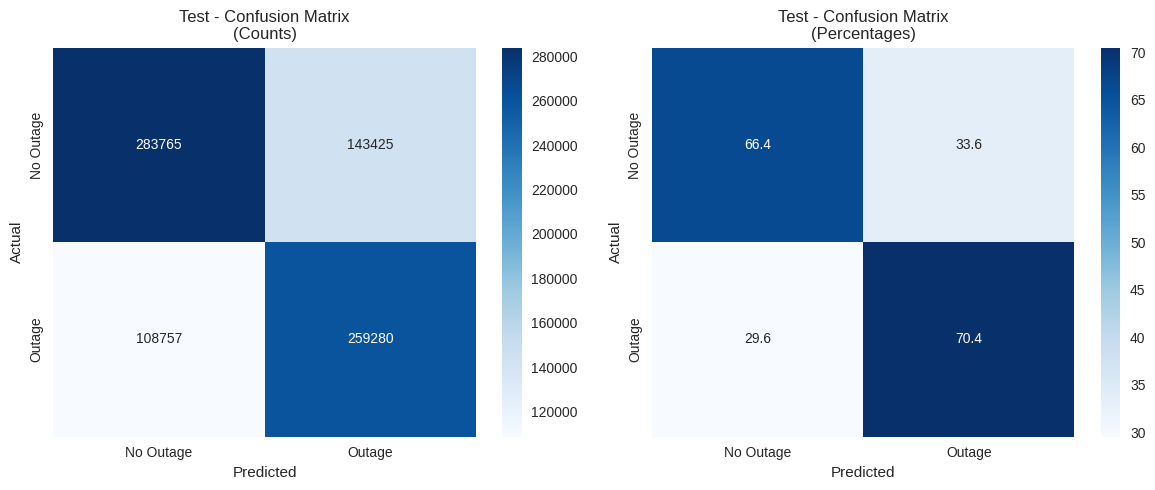


Test Confusion Matrix Insights:
True Negatives (Correct non-outages): 283,765
False Positives (False alarms): 143,425
False Negatives (Missed outages): 108,757 ← Most critical
True Positives (Detected outages): 259,280
Outage Detection Rate: 0.704


In [8]:
# Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, dataset_name):
    """Plot confusion matrix with percentages"""
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['No Outage', 'Outage'],
                yticklabels=['No Outage', 'Outage'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title(f'{dataset_name} - Confusion Matrix\n(Counts)')

    # Plot percentages
    sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
                xticklabels=['No Outage', 'Outage'],
                yticklabels=['No Outage', 'Outage'])
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    ax2.set_title(f'{dataset_name} - Confusion Matrix\n(Percentages)')

    plt.tight_layout()
    plt.show()

    # Print key confusion matrix insights
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{dataset_name} Confusion Matrix Insights:")
    print(f"True Negatives (Correct non-outages): {tn:,}")
    print(f"False Positives (False alarms): {fp:,}")
    print(f"False Negatives (Missed outages): {fn:,} \u2190 Most critical")
    print(f"True Positives (Detected outages): {tp:,}")
    print(f"Outage Detection Rate: {tp/(tp+fn):.3f}")

    return cm

# Plot confusion matrices for all sets
print("CONFUSION MATRIX ANALYSIS")
print("=" * 50)
test_cm = plot_confusion_matrix(y_test, y_test_pred, "Test")


ROC-AUC ANALYSIS


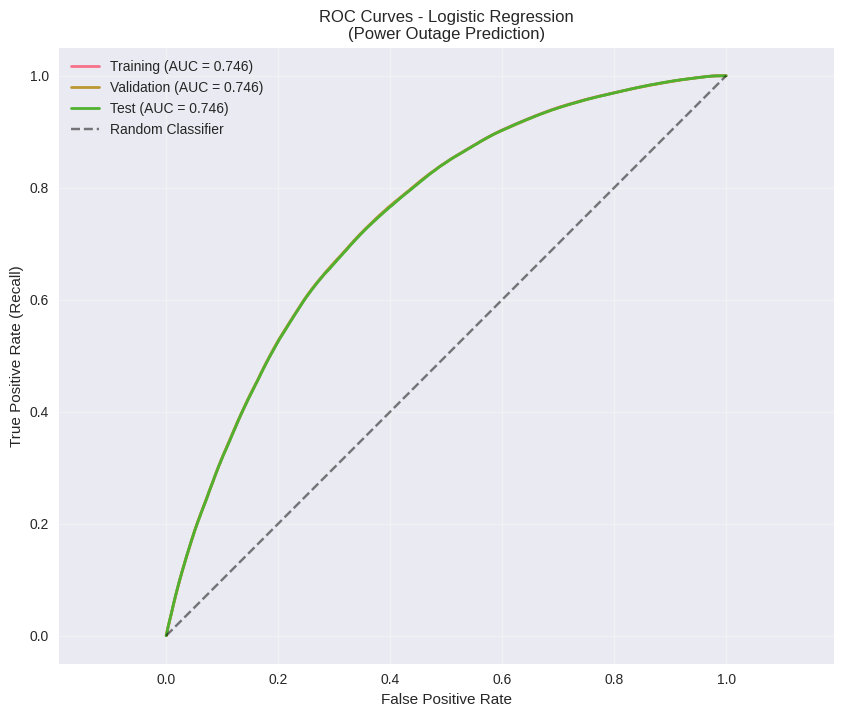

ROC-AUC Scores:
Training:   0.7463
Validation: 0.7464
Test:       0.7459


In [9]:
# ROC Curve Analysis
def plot_roc_curves(y_train_true, y_train_proba, y_val_true, y_val_proba, y_test_true, y_test_proba):
    """Plot ROC curves for all datasets"""
    plt.figure(figsize=(10, 8))

    # Calculate ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val_true, y_val_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_proba)

    # Calculate AUC scores
    auc_train = roc_auc_score(y_train_true, y_train_proba)
    auc_val = roc_auc_score(y_val_true, y_val_proba)
    auc_test = roc_auc_score(y_test_true, y_test_proba)

    # Plot ROC curves
    plt.plot(fpr_train, tpr_train, label=f'Training (AUC = {auc_train:.3f})', linewidth=2)
    plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {auc_val:.3f})', linewidth=2)
    plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc_test:.3f})', linewidth=2)

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curves - Logistic Regression\n(Power Outage Prediction)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

    print(f"ROC-AUC Scores:")
    print(f"Training:   {auc_train:.4f}")
    print(f"Validation: {auc_val:.4f}")
    print(f"Test:       {auc_test:.4f}")

    return {
        'train': (fpr_train, tpr_train, auc_train),
        'val': (fpr_val, tpr_val, auc_val),
        'test': (fpr_test, tpr_test, auc_test)
    }

# Plot ROC curves
print("\nROC-AUC ANALYSIS")
print("=" * 40)
roc_data = plot_roc_curves(y_train, y_train_proba, y_val, y_val_proba, y_test, y_test_proba)


FEATURE COEFFICIENT ANALYSIS


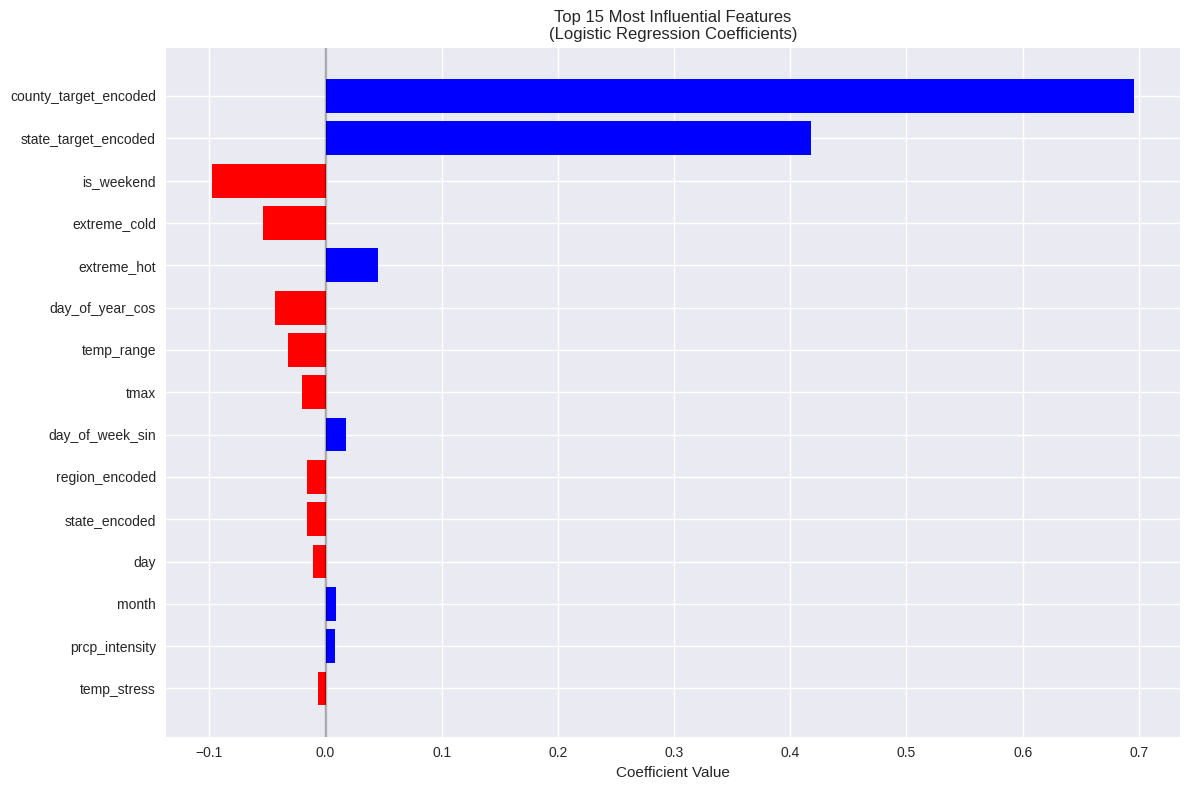


Top 15 Most Influential Features:
Positive coefficients → Higher outage probability
Negative coefficients → Lower outage probability
              feature  coefficient  abs_coefficient
county_target_encoded     0.695779         0.695779
 state_target_encoded     0.417460         0.417460
           is_weekend    -0.098055         0.098055
         extreme_cold    -0.054249         0.054249
          extreme_hot     0.044769         0.044769
      day_of_year_cos    -0.043561         0.043561
           temp_range    -0.032460         0.032460
                 tmax    -0.020075         0.020075
      day_of_week_sin     0.017947         0.017947
       region_encoded    -0.016128         0.016128
        state_encoded    -0.015850         0.015850
                  day    -0.011092         0.011092
                month     0.008875         0.008875
       prcp_intensity     0.007954         0.007954
          temp_stress    -0.006776         0.006776


In [10]:
# Feature Coefficient Analysis (Logistic Regression equivalent of Feature Importance)
def plot_feature_coefficients(model, feature_names, top_n=15):
    """Plot feature coefficients for Logistic Regression"""
    coefficients = model.coef_[0]

    # Create coefficient dataframe
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'abs_coefficient': np.abs(coefficients)
    }).sort_values('abs_coefficient', ascending=False)

    # Plot top N features by absolute coefficient
    plt.figure(figsize=(12, 8))

    top_features = coef_df.head(top_n)
    colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]

    plt.barh(range(len(top_features)), top_features['coefficient'][::-1], color=colors[::-1])
    plt.yticks(range(len(top_features)), top_features['feature'][::-1])
    plt.xlabel('Coefficient Value')
    plt.title(f'Top {top_n} Most Influential Features\n(Logistic Regression Coefficients)')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nTop {top_n} Most Influential Features:")
    print("Positive coefficients \u2192 Higher outage probability")
    print("Negative coefficients \u2192 Lower outage probability")
    print(top_features.head(top_n).to_string(index=False))

    return coef_df

# Plot feature coefficients
print("\nFEATURE COEFFICIENT ANALYSIS")
print("=" * 45)
feature_coef_df = plot_feature_coefficients(lr_model, feature_cols, top_n=15)


THRESHOLD OPTIMIZATION ANALYSIS


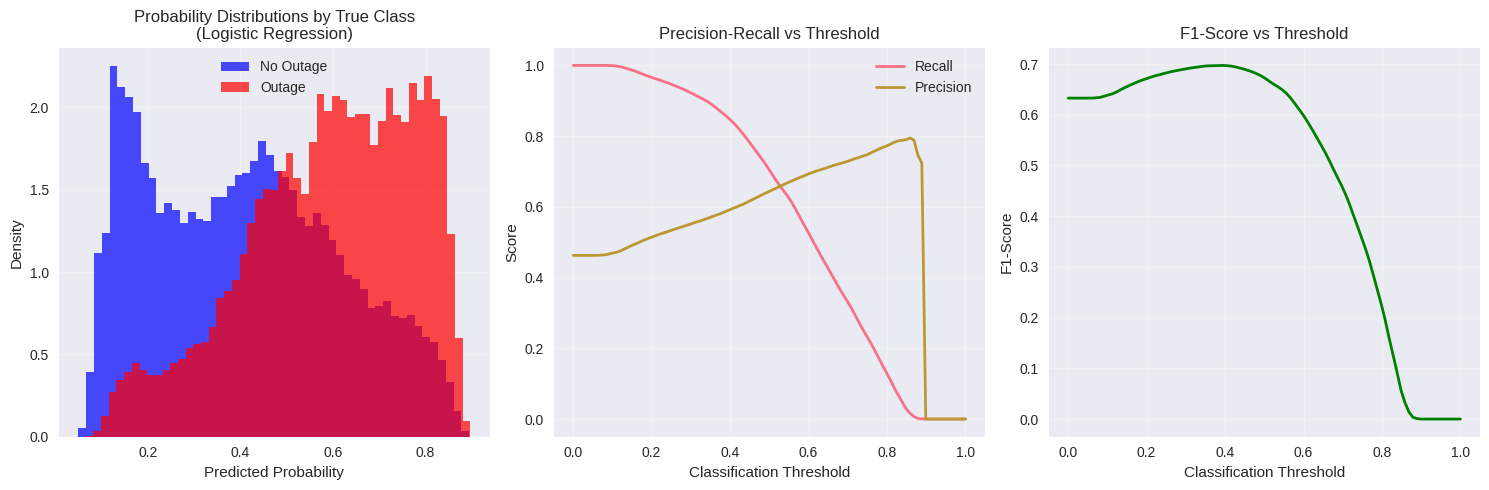

Optimal threshold (max F1): 0.394
F1-score at optimal threshold: 0.697
Recall at optimal threshold: 0.853
Precision at optimal threshold: 0.590


In [11]:
# Probability Distribution and Threshold Analysis
def plot_probability_distributions(y_test_true, y_test_proba, model_name="Logistic Regression"):
    """Plot probability distributions for both classes"""
    plt.figure(figsize=(15, 5))

    # Probability distributions
    plt.subplot(1, 3, 1)
    plt.hist(y_test_proba[y_test_true == 0], bins=50, alpha=0.7,
             label='No Outage', color='blue', density=True)
    plt.hist(y_test_proba[y_test_true == 1], bins=50, alpha=0.7,
             label='Outage', color='red', density=True)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title(f'Probability Distributions by True Class\n({model_name})')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Precision-Recall tradeoff at different thresholds
    plt.subplot(1, 3, 2)
    thresholds = np.linspace(0, 1, 100)
    recalls = []
    precisions = []

    for thresh in thresholds:
        y_pred_thresh = (y_test_proba >= thresh).astype(int)
        recalls.append(recall_score(y_test_true, y_pred_thresh))
        precisions.append(precision_score(y_test_true, y_pred_thresh))

    plt.plot(thresholds, recalls, label='Recall', linewidth=2)
    plt.plot(thresholds, precisions, label='Precision', linewidth=2)
    plt.xlabel('Classification Threshold')
    plt.ylabel('Score')
    plt.title('Precision-Recall vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # F1-score vs threshold
    plt.subplot(1, 3, 3)
    f1_scores = []
    for thresh in thresholds:
        y_pred_thresh = (y_test_proba >= thresh).astype(int)
        f1_scores.append(f1_score(y_test_true, y_pred_thresh))

    plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2, color='green')
    plt.xlabel('Classification Threshold')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs Threshold')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Find optimal threshold (maximizing F1-score)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    print(f"Optimal threshold (max F1): {optimal_threshold:.3f}")
    print(f"F1-score at optimal threshold: {f1_scores[optimal_idx]:.3f}")
    print(f"Recall at optimal threshold: {recalls[optimal_idx]:.3f}")
    print(f"Precision at optimal threshold: {precisions[optimal_idx]:.3f}")

    return optimal_threshold, recalls[optimal_idx], precisions[optimal_idx], f1_scores[optimal_idx]

# Plot probability analysis
print("\nTHRESHOLD OPTIMIZATION ANALYSIS")
print("=" * 45)
optimal_threshold, opt_recall, opt_precision, opt_f1 = plot_probability_distributions(y_test, y_test_proba, "Logistic Regression")

In [12]:
# Evaluate with optimal threshold
y_test_optimal = (y_test_proba >= optimal_threshold).astype(int)

print("\n" + "="*60)
print("PERFORMANCE AT OPTIMAL THRESHOLD (Max F1)")
print("="*60)
print(f"Threshold: {optimal_threshold:.3f}")

optimal_metrics = evaluate_model(y_test, y_test_optimal, y_test_proba, "Test (Optimal Threshold)")

# Compare with default threshold performance
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION COMPARISON")
print("="*70)
print(f"{'Metric':<15} {'Default (0.5)':<12} {'Optimal':<12} {'Improvement':<12}")
print(f"{'-'*70}")
print(f"{'Accuracy':<15} {test_metrics['accuracy']:.4f}      {optimal_metrics['accuracy']:.4f}      {optimal_metrics['accuracy'] - test_metrics['accuracy']:+.4f}")
print(f"{'Recall':<15} {test_metrics['recall']:.4f}      {optimal_metrics['recall']:.4f}      {optimal_metrics['recall'] - test_metrics['recall']:+.4f}")
print(f"{'Precision':<15} {test_metrics['precision']:.4f}      {optimal_metrics['precision']:.4f}      {optimal_metrics['precision'] - test_metrics['precision']:+.4f}")
print(f"{'F1-Score':<15} {test_metrics['f1_score']:.4f}      {optimal_metrics['f1_score']:.4f}      {optimal_metrics['f1_score'] - test_metrics['f1_score']:+.4f}")


PERFORMANCE AT OPTIMAL THRESHOLD (Max F1)
Threshold: 0.394

TEST (OPTIMAL THRESHOLD) SET EVALUATION
Accuracy:  0.6571
Recall:    0.8530  ← Most important for outage prediction
Precision: 0.5895
F1-Score:  0.6972
ROC-AUC:   0.7459

Class Distribution:
Class 0 (No Outage): 427,190 samples
Class 1 (Outage):    368,037 samples
Outage Rate: 0.463

THRESHOLD OPTIMIZATION COMPARISON
Metric          Default (0.5) Optimal      Improvement 
----------------------------------------------------------------------
Accuracy        0.6829      0.6571      -0.0258
Recall          0.7045      0.8530      +0.1485
Precision       0.6438      0.5895      -0.0543
F1-Score        0.6728      0.6972      +0.0244


In [13]:
from pathlib import Path # Ensure Path is imported in this cell


# Model Comparison with Gradient Boosting (if available)
def load_gb_metrics():
    """Load Gradient Boosting metrics for comparison"""
    try:
        gb_metrics_path = MODELS_DIR / "gradient_boosting" / "model_metrics.csv"
        if gb_metrics_path.exists():
            gb_metrics = pd.read_csv(gb_metrics_path)
            gb_test_metrics = gb_metrics[gb_metrics['dataset'] == 'test'].iloc[0]
            return gb_test_metrics
    except Exception as e:
        print(f"Error loading Gradient Boosting metrics: {e}")
        pass
    return None

gb_metrics = load_gb_metrics()

if gb_metrics is not None:
    print("\n" + "="*70)
    print("MODEL COMPARISON: LOGISTIC REGRESSION vs GRADIENT BOOSTING")
    print("="*70)
    print(f"{'Metric':<15} {'Logistic Regression':<20} {'Gradient Boosting':<20} {'Difference':<12}")
    print(f"{'-'*70}")
    print(f"{'Accuracy':<15} {test_metrics['accuracy']:.4f}             {gb_metrics['accuracy']:.4f}              {test_metrics['accuracy'] - gb_metrics['accuracy']:+.4f}")
    print(f"{'Recall':<15} {test_metrics['recall']:.4f}             {gb_metrics['recall']:.4f}              {test_metrics['recall'] - gb_metrics['recall']:+.4f}")
    print(f"{'Precision':<15} {test_metrics['precision']:.4f}             {gb_metrics['precision']:.4f}              {test_metrics['precision'] - gb_metrics['precision']:+.4f}")
    print(f"{'F1-Score':<15} {test_metrics['f1_score']:.4f}             {gb_metrics['f1_score']:.4f}              {test_metrics['f1_score'] - gb_metrics['f1_score']:+.4f}")
    print(f"{'ROC-AUC':<15} {test_metrics['roc_auc']:.4f}             {gb_metrics['roc_auc']:.4f}              {test_metrics['roc_auc'] - gb_metrics['roc_auc']:+.4f}")
else:
    print("\nGradient Boosting metrics not found. Skipping model comparison.")


MODEL COMPARISON: LOGISTIC REGRESSION vs GRADIENT BOOSTING
Metric          Logistic Regression  Gradient Boosting    Difference  
----------------------------------------------------------------------
Accuracy        0.6829             0.7042              -0.0213
Recall          0.7045             0.6837              +0.0208
Precision       0.6438             0.6793              -0.0354
F1-Score        0.6728             0.6815              -0.0087
ROC-AUC         0.7459             0.7768              -0.0309


In [14]:
import pandas as pd # Ensure pandas is imported in this cell

# Save model and results OPTIONAL
def save_model_and_results(model, scaler, metrics, feature_coef, output_dir):
    """Save model, scaler, and evaluation results"""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Save model
    joblib.dump(model, output_dir / "logistic_regression_model.pkl")
    joblib.dump(scaler, output_dir / "feature_scaler.pkl")

    # Save metrics
    metrics_df = pd.DataFrame({
        'dataset': ['training', 'validation', 'test'],
        'accuracy': [metrics['train']['accuracy'], metrics['val']['accuracy'], metrics['test']['accuracy']],
        'recall': [metrics['train']['recall'], metrics['val']['recall'], metrics['test']['recall']],
        'precision': [metrics['train']['precision'], metrics['val']['precision'], metrics['test']['precision']],
        'f1_score': [metrics['train']['f1_score'], metrics['val']['f1_score'], metrics['test']['f1_score']],
        'roc_auc': [metrics['train']['roc_auc'], metrics['val']['roc_auc'], metrics['test']['roc_auc']]
    })
    metrics_df.to_csv(output_dir / "model_metrics.csv", index=False)

    # Save feature coefficients
    feature_coef.to_csv(output_dir / "feature_coefficients.csv", index=False)

    # Save configuration
    config = {
        'model_type': 'LogisticRegression',
        'feature_count': len(feature_cols),
        'optimal_threshold': float(optimal_threshold),
        'training_samples': len(y_train),
        'test_samples': len(y_test),
        'model_parameters': {
            'C': 1.0,
            'class_weight': 'balanced',
            'solver': 'liblinear',
            'penalty': 'l2',
            'max_iter': 1000
        }
    }

    with open(output_dir / "model_config.json", 'w') as f:
        json.dump(config, f, indent=2)

    print(f"\n Logistic Regression model and results saved to: {output_dir}")

save_model_and_results(
    lr_model,
    scaler,
    {'train': train_metrics, 'val': val_metrics, 'test': optimal_metrics}, # Use optimal_metrics for the test set
    feature_coef_df,
    MODELS_DIR / "logistic_regression"
)


 Logistic Regression model and results saved to: /content/drive/MyDrive/ABT_Global/AI-Studio-Project/models/logistic_regression


In [15]:
# Load and display saved metrics to verify
try:
    saved_metrics = pd.read_csv(MODELS_DIR / "logistic_regression" / "model_metrics.csv")
    print("\nSaved Metrics Verification:")
    print(saved_metrics.to_string(index=False))
except:
    print("Could not load saved metrics for verification")


Saved Metrics Verification:
   dataset  accuracy   recall  precision  f1_score  roc_auc
  training  0.683184 0.704520   0.644225  0.673025 0.746337
validation  0.683577 0.704252   0.644796  0.673214 0.746375
      test  0.657104 0.853042   0.589530  0.697218 0.745934
